In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bern-eeg-dataset/Data_F_50/Data_F_Ind0041.txt
/kaggle/input/bern-eeg-dataset/Data_F_50/Data_F_Ind0001.txt
/kaggle/input/bern-eeg-dataset/Data_F_50/Data_F_Ind0015.txt
/kaggle/input/bern-eeg-dataset/Data_F_50/Data_F_Ind0044.txt
/kaggle/input/bern-eeg-dataset/Data_F_50/Data_F_Ind0006.txt
/kaggle/input/bern-eeg-dataset/Data_F_50/Data_F_Ind0021.txt
/kaggle/input/bern-eeg-dataset/Data_F_50/Data_F_Ind0047.txt
/kaggle/input/bern-eeg-dataset/Data_F_50/Data_F_Ind0029.txt
/kaggle/input/bern-eeg-dataset/Data_F_50/Data_F_Ind0034.txt
/kaggle/input/bern-eeg-dataset/Data_F_50/Data_F_Ind0005.txt
/kaggle/input/bern-eeg-dataset/Data_F_50/Data_F_Ind0031.txt
/kaggle/input/bern-eeg-dataset/Data_F_50/Data_F_Ind0013.txt
/kaggle/input/bern-eeg-dataset/Data_F_50/Data_F_Ind0048.txt
/kaggle/input/bern-eeg-dataset/Data_F_50/Data_F_Ind0045.txt
/kaggle/input/bern-eeg-dataset/Data_F_50/Data_F_Ind0019.txt
/kaggle/input/bern-eeg-dataset/Data_F_50/Data_F_Ind0023.txt
/kaggle/input/bern-eeg-dataset/Data_F_50

In [2]:
!pip install pyts

  Obtaining dependency information for pyts from https://files.pythonhosted.org/packages/b3/e3/da2042a20782b105631abe273ca5fef4390e7bdb6f5377c596891262437b/pyts-0.13.0-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 23.2 MB/s eta 0:00:0000:0100:01


In [3]:
import numpy as np
import os
from pyts.image import GramianAngularField, RecurrencePlot
import matplotlib.pyplot as plt

# Function to read signals from files and segment them
def read_and_segment_signals(directory, segment_size):
    segmented_signals = []
    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)
        if os.path.isfile(file_path):
            # Load the entire signal
            signal = np.loadtxt(file_path, delimiter=',', usecols=[0])
            # Split the signal into segments of the specified size
            for start_idx in range(0, len(signal) - segment_size + 1, segment_size):
                segment = signal[start_idx:start_idx + segment_size]
                segmented_signals.append(segment)
    return segmented_signals

# Function to apply GASF transformation to each segment
def apply_gasf_to_segments(segments):
    gasf = GramianAngularField(image_size=segments[0].shape[0])
    gasf_images = gasf.fit_transform(segments)
    return gasf_images

def apply_rp_to_segments(segments):
    # Initialize the Recurrence Plot transformer
    rp = RecurrencePlot()
    # Transform each segment
    rp_images = rp.fit_transform(segments)
    return rp_images


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
segment_size = 256
focal_directory = '/kaggle/input/bern-eeg-dataset/Data_F_50'  
non_focal_directory = '/kaggle/input/bern-eeg-dataset/Data_N_50' 

# Read and segment the signals
focal_segments = read_and_segment_signals(focal_directory, segment_size)
non_focal_segments = read_and_segment_signals(non_focal_directory, segment_size)

# Apply GASF transformation
focal_gasf_images = apply_gasf_to_segments(focal_segments)
non_focal_gasf_images = apply_gasf_to_segments(non_focal_segments)


In [5]:
def visualize_gasf_images(focal_image, non_focal_image):
    """
    Visualizes one focal and one non-focal GASF image side by side.

    Parameters:
    - focal_image: A 2D NumPy array representing the focal GASF image.
    - non_focal_image: A 2D NumPy array representing the non-focal GASF image.
    """
    # Set up the figure and axes
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # Plot the focal GASF image
    axs[0].imshow(focal_image, cmap='jet', aspect='auto')
    axs[0].set_title('Focal GASF Image')

    # Plot the non-focal GASF image
    axs[1].imshow(non_focal_image, cmap='jet', aspect='auto')
    axs[1].set_title('Non-Focal GASF Image')

    # Display the plot
    plt.tight_layout()
    plt.show()

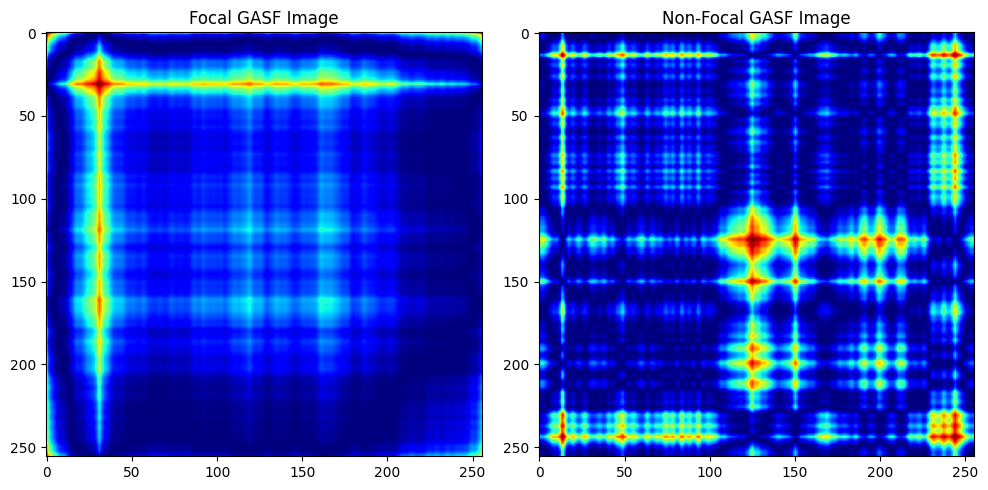

In [6]:
visualize_gasf_images(focal_gasf_images[5], non_focal_gasf_images[1])

In [7]:
import torch
from sklearn.model_selection import StratifiedShuffleSplit
from torch.utils.data import Dataset, DataLoader, random_split, Subset
import copy
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
cudnn.benchmark = True
plt.ion()   # interactive mode
from sklearn.model_selection import train_test_split


In [8]:
def apply_pseudocolor(gasf_image, cmap='jet'):
    # Normalize the GASF image to the range [0, 1]
    gasf_image_normalized = (gasf_image - np.min(gasf_image)) / (np.max(gasf_image) - np.min(gasf_image))
    
    # Apply a colormap (pseudocolor)
    pseudocolor_image = plt.get_cmap(cmap)(gasf_image_normalized)[:, :, :3]  # Drop the alpha channel
    return pseudocolor_image


In [9]:
class SingleChannelToRGB:
    def __init__(self, cmap='jet'):
        self.cmap = plt.get_cmap(cmap)
    
    def __call__(self, image):
        # Normalize the image to the range [0, 1]
        image_normalized = (image - np.min(image)) / (np.max(image) - np.min(image))
        
        # Apply the colormap (pseudocolor) to the normalized image
        pseudocolor_image = self.cmap(image_normalized)[:, :, :3]  # Drop the alpha channel
        
        # Return the 3-channel RGB image
        return (pseudocolor_image * 255).astype(np.uint8)  # Scale back to 0-255
    
# Transformation pipeline
transform = transforms.Compose([
    transforms.Lambda(lambda x: SingleChannelToRGB(cmap='jet')(x)),  # Convert single-channel to RGB
    transforms.Lambda(lambda x: Image.fromarray(x)),                # Convert numpy array to PIL Image
    transforms.Resize((224, 224)),                                  # Resize image to fit model input
    transforms.ToTensor()                                           # Convert image to PyTorch Tensor
])


In [10]:
class GASFImageDataset(Dataset):
    def __init__(self, focal_data, non_focal_data, transform=None):
        self.data = np.concatenate((non_focal_gasf_images, focal_gasf_images), axis=0)
        self.labels = [1] * len(focal_data) + [0] * len(non_focal_data)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]  
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label


In [11]:
#def split_data(focal_data, non_focal_data, transform, train_ratio=0.8):

#     dataset = GASFImageDataset(focal_data, non_focal_data, transform=transform)
#     train_size = int(train_ratio * len(dataset))
#     val_size = len(dataset) - train_size
#     train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
#     return train_dataset, val_dataset

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [13]:
# Custom transformation to convert a single-channel image to a 3-channel (RGB) image
# class SingleChannelToRGB:
#     def __call__(self, image):
#         # Stack the single channel image to create a 3-channel image
#         return np.stack([image] * 3, axis=-1)

# # Transformation pipeline
# transform = transforms.Compose([
#     transforms.Lambda(lambda x: (x * 255).astype(np.uint8)),  # Scale the numpy array to 0-255
#     transforms.Lambda(lambda x: SingleChannelToRGB()(x)),     # Convert single-channel to RGB
#     transforms.Lambda(lambda x: Image.fromarray(x)),          # Convert numpy array to PIL Image
#     transforms.Resize((224, 224)),                            # Resize image to fit model input
#     transforms.ToTensor(),                                   # Convert image to PyTorch Tensor
# ])

In [14]:
# Split the data
# train_dataset, val_dataset = split_data(focal_gasf_images, non_focal_gasf_images, transform)

# # data loaders dictionary
# dataloaders = {
#     'train': DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4),
#     'val': DataLoader(val_dataset, batch_size=16, shuffle=True, num_workers=4)
# }

# dataset_sizes = {
#     'train': len(train_dataset),
#     'val': len(val_dataset)def split_data(focal_data, non_focal_data, transform, train_ratio=0.8):

#     dataset = GASFImageDataset(focal_data, non_focal_data, transform=transform)
#     train_size = int(train_ratio * len(dataset))
#     val_size = len(dataset) - train_size
#     train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
#     return train_dataset, val_dataset
# }

# class_names = ['focal', 'non_focal']

In [15]:
from collections import Counter

In [16]:
def split_data(focal_data, non_focal_data, transform):
    # Create the dataset
    dataset = GASFImageDataset(focal_data, non_focal_data, transform=transform)
    
    # Split the data into training and validation sets using stratified sampling
    train_idx, val_idx = train_test_split(
        np.arange(len(dataset.labels)),
        test_size=0.2,
        random_state=42,
        stratify=dataset.labels
    )
    
    # Create subsets for training and validation
    train_dataset = Subset(dataset, train_idx)
    val_dataset = Subset(dataset, val_idx)
    # Extract labels for the training set
    train_labels = [dataset.labels[i] for i in train_dataset.indices]

    # Extract labels for the validation set
    val_labels = [dataset.labels[i] for i in val_dataset.indices]
    print("Label distribution in the training set:", Counter(train_labels))
    print("Label distribution in the validation set:", Counter(val_labels))

    return train_dataset, val_dataset
# Split the data
train_dataset, val_dataset = split_data(focal_gasf_images, non_focal_gasf_images, transform)

# Data loaders dictionary
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4),
    'val': DataLoader(val_dataset, batch_size=16, shuffle=True, num_workers=4)
}

dataset_sizes = {
    'train': len(train_dataset),
    'val': len(val_dataset)
}

class_names = ['non_focal', 'focal']


Label distribution in the training set: Counter({1: 1600, 0: 1600})
Label distribution in the validation set: Counter({1: 400, 0: 400})


In [17]:
for input, labels in dataloaders["train"]:
    print(input)
    print(labels)
    break

tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0745, 0.0118, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0118, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0235, 0.1137, 0.1765,  ..., 0.4588, 0.3333, 0.1922],
          [0.1137, 0.1922, 0.2667,  ..., 0.5686, 0.4392, 0.2863],
          [0.1765, 0.2667, 0.3373,  ..., 0.6549, 0.5176, 0.3608],
          ...,
          [0.4588, 0.5686, 0.6549,  ..., 0.9647, 0.8431, 0.6745],
          [0.3333, 0.4392, 0.5176,  ..., 0.8431, 0.7059, 0.5373],
          [0.1922, 0.2863, 0.3608,  ..., 0.6745, 0.5373, 0.3765]],

         [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1

In [18]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    
    metrics = {
        'train': {'loss': [], 'precision': [], 'recall': [], 'f1': [], 'auc': []},
        'val': {'loss': [], 'precision': [], 'recall': [], 'f1': [], 'auc': []}
    }
    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0
        best_auc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0
                all_preds = []
                all_labels = []
                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                    all_preds.extend(preds.cpu().numpy())
                    all_labels.extend(labels.cpu().numpy())
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]
                
                # Calculate metrics
                epoch_precision = precision_score(all_labels, all_preds)
                epoch_recall = recall_score(all_labels, all_preds)
                epoch_f1 = f1_score(all_labels, all_preds)
                epoch_auc = roc_auc_score(all_labels, all_preds)

                # Save metrics
                metrics[phase]['loss'].append(epoch_loss)
                metrics[phase]['precision'].append(epoch_precision)
                metrics[phase]['recall'].append(epoch_recall)
                metrics[phase]['f1'].append(epoch_f1)
                metrics[phase]['auc'].append(epoch_auc)

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} Precision: {epoch_precision:.4f} Recall: {epoch_recall:.4f} F1: {epoch_f1:.4f} AUC: {epoch_auc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_auc > best_auc:
                    best_auc = epoch_auc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val AUC: {best_auc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model, metrics

In [19]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')

for param in model_ft.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)


model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model_ft.parameters(), lr=0.0001) 

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 193MB/s] 


In [21]:
model_resnet, metrics_resnet = train_model(model_ft, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=6)

Epoch 0/5
----------
train Loss: 0.6387 Acc: 0.6428 Precision: 0.6496 Recall: 0.6200 F1: 0.6345 AUC: 0.6428
val Loss: 0.6071 Acc: 0.6975 Precision: 0.6936 Recall: 0.7075 F1: 0.7005 AUC: 0.6975

Epoch 1/5
----------
train Loss: 0.5928 Acc: 0.7009 Precision: 0.6983 Recall: 0.7075 F1: 0.7029 AUC: 0.7009
val Loss: 0.5908 Acc: 0.7225 Precision: 0.7572 Recall: 0.6550 F1: 0.7024 AUC: 0.7225

Epoch 2/5
----------
train Loss: 0.5765 Acc: 0.7063 Precision: 0.7055 Recall: 0.7081 F1: 0.7068 AUC: 0.7063
val Loss: 0.5804 Acc: 0.7300 Precision: 0.7347 Recall: 0.7200 F1: 0.7273 AUC: 0.7300

Epoch 3/5
----------
train Loss: 0.5715 Acc: 0.7203 Precision: 0.7213 Recall: 0.7181 F1: 0.7197 AUC: 0.7203
val Loss: 0.5802 Acc: 0.7325 Precision: 0.7768 Recall: 0.6525 F1: 0.7092 AUC: 0.7325

Epoch 4/5
----------
train Loss: 0.5618 Acc: 0.7191 Precision: 0.7254 Recall: 0.7050 F1: 0.7151 AUC: 0.7191
val Loss: 0.5765 Acc: 0.7075 Precision: 0.6836 Recall: 0.7725 F1: 0.7254 AUC: 0.7075

Epoch 5/5
----------
train Los

In [57]:
def plot_metrics(metrics):
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.ravel()
    for i, metric in enumerate(['loss', 'precision', 'recall', 'f1', 'auc']):
        axes[i].plot(metrics['train'][metric], label='Train')
        axes[i].plot(metrics['val'][metric], label='Validation')
        if (metric == "loss"):
            axes[i].set_title("Training and Validation Loss")
        elif(metric == "auc"):
            axes[i].set_title("Training and Validation AUC")
        else:
            axes[i].set_title(metric)
        axes[i].set_xlabel("Epochs")
        axes[i].set_ylabel("Loss")
        axes[i].legend()
    plt.tight_layout()
    plt.show()


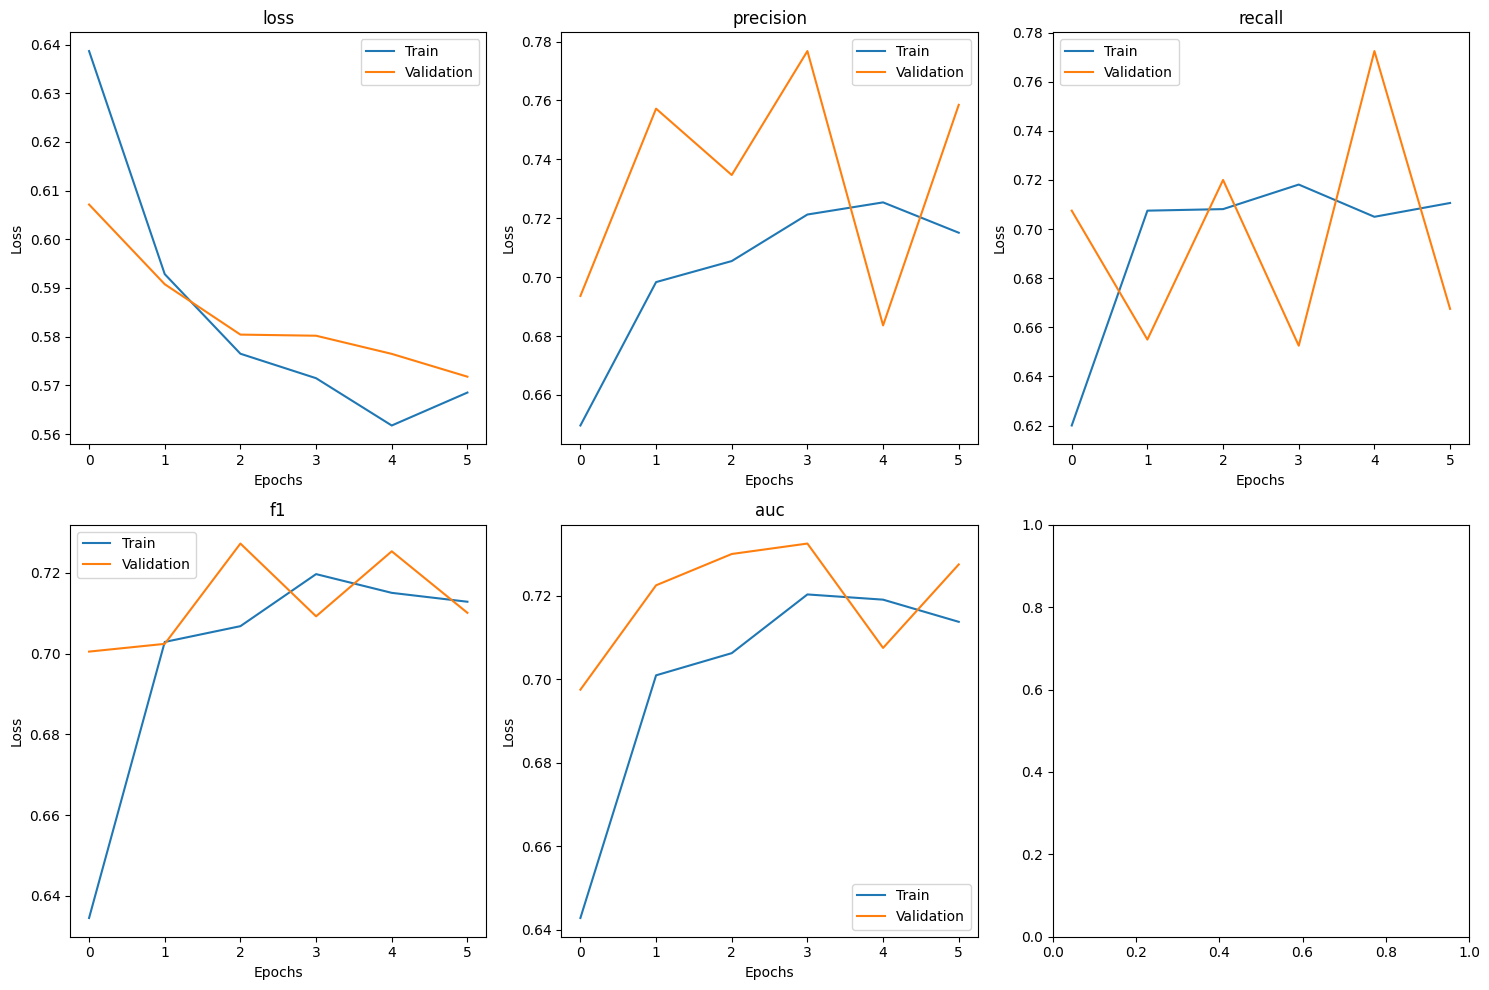

In [28]:
plot_metrics(metrics_resnet)

In [ ]:
vgg16 = models.vgg16(pretrained=True)

#for param in vgg16.parameters():
 #   vgg16.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_features = vgg16.classifier[6].in_features
vgg16.classifier[6] = torch.nn.Linear(num_features, 2) 

vgg16 = vgg16.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(vgg16.parameters(), lr=0.0001)  


# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

In [ ]:
model_vgg16, metrics_vgg16 = train_model(vgg16, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=7)

In [ ]:
plot_metrics(metrics_vgg16)

In [ ]:
alexnet = models.alexnet(pretrained=True)

for param in alexnet.parameters():
    alexnet.requires_grad = False

num_classes = 2  
alexnet.classifier[6] = nn.Linear(alexnet.classifier[6].in_features, num_classes)


alexnet = alexnet.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(alexnet.parameters(), lr=0.0001)  


# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

In [ ]:
model_alex, metrics_alex = train_model(alexnet, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=7)

In [ ]:
plot_metrics(metrics_alex)

In [30]:
class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        
        # ConvNet-1: Convolutional layer with 32 filters, kernel size 3x3, stride 1, and ReLU activation
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1)
        
        # ConvNet-2: Convolutional layer with 64 filters, kernel size 3x3, stride 2, and ReLU activation
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2)
        
        # ConvNet-3: Convolutional layer with 64 filters, kernel size 3x3, stride 2, and ReLU activation
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=2)
        
        # Batch Normalization
        self.batch_norm = nn.BatchNorm2d(num_features=64)
        
        # Max Pooling: 2x2 pool size
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Flatten layer
        self.flatten = nn.Flatten()
        
        # Dense-1: Fully connected layer with 1024 output units and Sigmoid activation
        self.fc1 = nn.Linear(in_features=46656, out_features=1024)
        
        # Dense-2: Fully connected layer with 512 output units and Sigmoid activation
        self.fc2 = nn.Linear(in_features=1024, out_features=512)
        
        # Dense-3: Fully connected layer with 2 output units and SoftMax activation (output layer)
        self.fc3 = nn.Linear(in_features=512, out_features=2)

    def forward(self, x):
        # Apply ConvNet-1 and ReLU activation
        x = F.relu(self.conv1(x))
        # Apply ConvNet-2 and ReLU activation
        x = F.relu(self.conv2(x))
        # Apply ConvNet-3 and ReLU activation
        x = F.relu(self.conv3(x))
        # Apply Batch Normalization
        x = self.batch_norm(x)
        # Apply Max Pooling
        x = self.max_pool(x)
        # Flatten the output
        x = torch.flatten(x, 1)
        # Apply Dense-1 and Sigmoid activation
        x = torch.sigmoid(self.fc1(x))
        
        # Apply Dense-2 and Sigmoid activation
        x = torch.sigmoid(self.fc2(x))
        
        # Apply Dense-3 and use Softmax activation for the output layer
        x = F.softmax(self.fc3(x), dim=1)
        
        return x


In [47]:
import torch.nn.functional as F
custom_cnn = CustomCNN()
print(custom_cnn)


CustomCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2))
  (batch_norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=46656, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=2, bias=True)
)


In [48]:

custom_cnn = custom_cnn.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(custom_cnn.parameters(), lr=0.0001)  


# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [49]:
model_cnn, metrics_cnn = train_model(custom_cnn, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=50)

Epoch 0/49
----------
train Loss: 0.6173 Acc: 0.6744 Precision: 0.6729 Recall: 0.6787 F1: 0.6758 AUC: 0.6744
val Loss: 0.6484 Acc: 0.6275 Precision: 0.5873 Recall: 0.8575 F1: 0.6972 AUC: 0.6275

Epoch 1/49
----------
train Loss: 0.5645 Acc: 0.7403 Precision: 0.7438 Recall: 0.7331 F1: 0.7384 AUC: 0.7403
val Loss: 0.5918 Acc: 0.6963 Precision: 0.7343 Recall: 0.6150 F1: 0.6694 AUC: 0.6962

Epoch 2/49
----------
train Loss: 0.5328 Acc: 0.7759 Precision: 0.7865 Recall: 0.7575 F1: 0.7717 AUC: 0.7759
val Loss: 0.6211 Acc: 0.6675 Precision: 0.7939 Recall: 0.4525 F1: 0.5764 AUC: 0.6675

Epoch 3/49
----------
train Loss: 0.5034 Acc: 0.8100 Precision: 0.8233 Recall: 0.7894 F1: 0.8060 AUC: 0.8100
val Loss: 0.5916 Acc: 0.7075 Precision: 0.7578 Recall: 0.6100 F1: 0.6759 AUC: 0.7075

Epoch 4/49
----------
train Loss: 0.4634 Acc: 0.8503 Precision: 0.8666 Recall: 0.8281 F1: 0.8469 AUC: 0.8503
val Loss: 0.5978 Acc: 0.6975 Precision: 0.7380 Recall: 0.6125 F1: 0.6694 AUC: 0.6975

Epoch 5/49
----------
tra

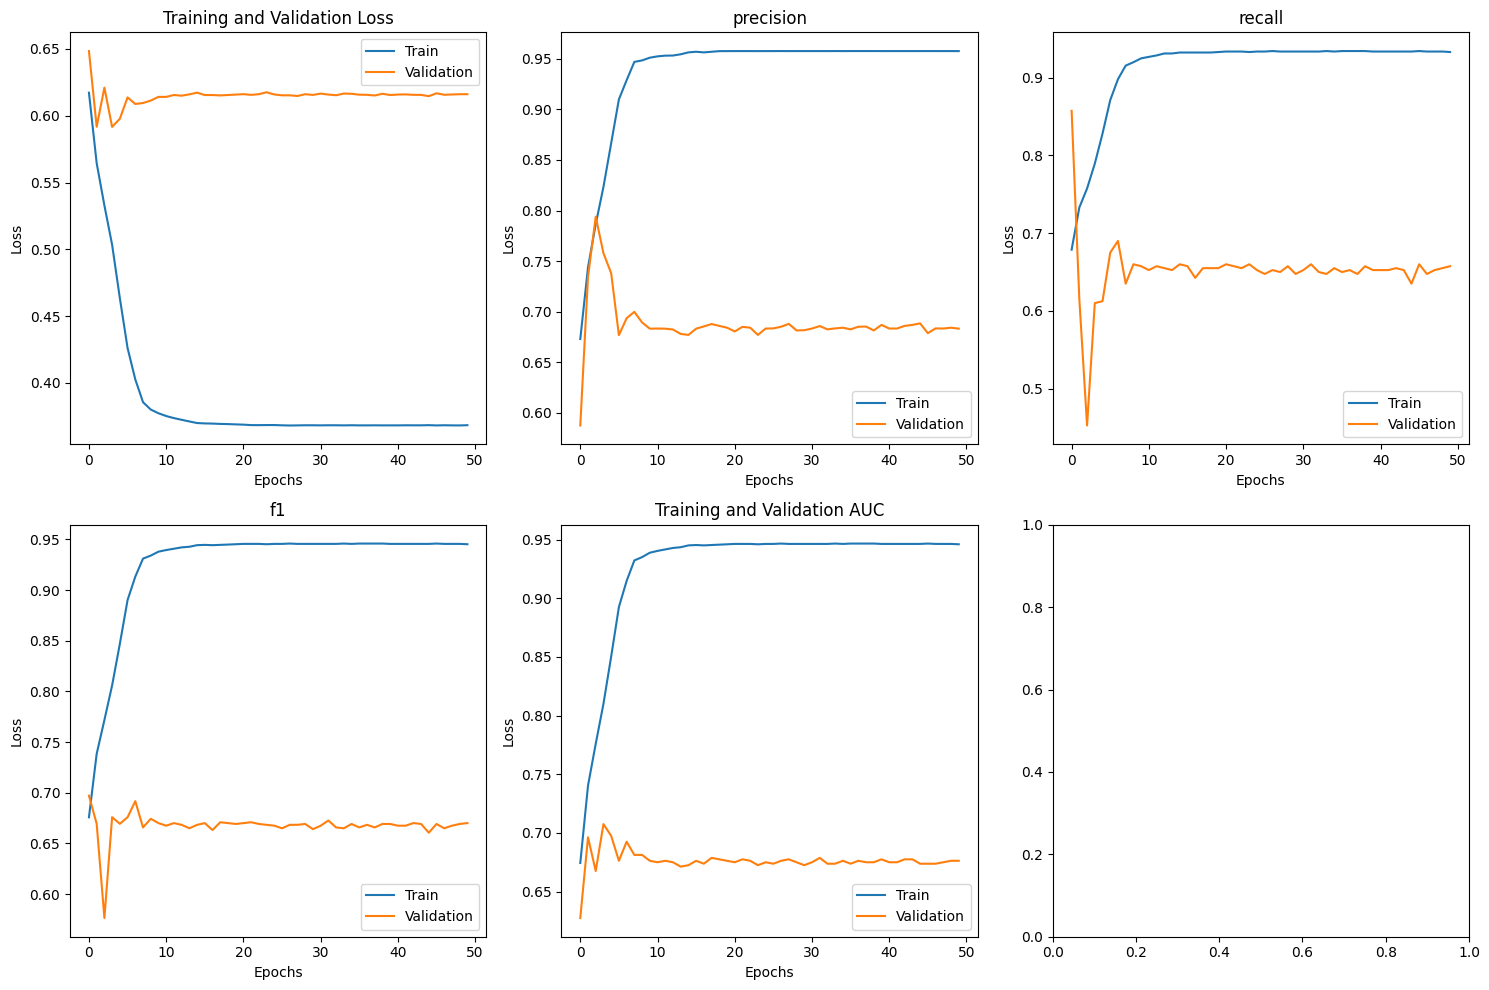

In [58]:
plot_metrics(metrics_cnn)